In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../Share/')
import baseline, config

sys.path.append('../')
import self_supervised_v1

import warnings
warnings.filterwarnings('ignore')

SUBJECT = "Harold"
Threshold_K = 4
trainer = baseline.ModelTrainer(config, subject=SUBJECT)
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
#trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

# 초기 학습 데이터
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
print(X_init.shape, y_init.shape, X_init_test.shape, y_init_test.shape)

Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
(27617, 4, 14, 1) (27617,) (6904, 4, 14, 1) (6904,)


In [3]:
def initialize_prototypes(model, X, y, num_classes=6):
    # 클래스별 prototype 계산
    prototypes = {}
    features = model.predict(X)
    for cls in range(num_classes):
        cls_features = features[y == cls]
        prototypes[cls] = np.mean(cls_features, axis=0)
    return prototypes


from sklearn.metrics.pairwise import cosine_similarity

def predict_with_prototypes(prototypes, features):
    # 각 feature에 대해 가장 유사한 prototype 선택
    preds = []
    proto_vectors = np.stack([prototypes[i] for i in sorted(prototypes.keys())])  # shape: [C, D]
    sims = cosine_similarity(features, proto_vectors)  # shape: [N, C]
    preds = np.argmax(sims, axis=1)
    return preds

def update_prototypes(prototypes, features, pseudo_labels, alpha=0.1):
    # pseudo_labels는 모델이 예측한 클래스
    for i, label in enumerate(pseudo_labels):
        prototypes[label] = (1 - alpha) * prototypes[label] + alpha * features[i]
    return prototypes


In [4]:
# Accuracy 저장 리스트
final_session = len(config.Info_sub_H2)
X_init, y_init, X_init_test, y_init_test = trainer.return_until_K_data(K=Threshold_K, train_ratio=0.8)
model = self_supervised_v1.build_encoder_model()  # 분류기 없이 encoder만


# 초기 프로토타입 생성
prototypes = initialize_prototypes(model, X_init, y_init)

Proto_Fixed_Acc = []

for session in range(Threshold_K, final_session-1):
    _, _, X_test, y_test = trainer.return_K_th_data_only(K=session, train_ratio=0.8)

    features = model.predict(X_test, verbose=0)
    preds = predict_with_prototypes(prototypes, features)
    acc = np.mean(preds == y_test)
    Proto_Fixed_Acc.append(acc)


Dataset 1/18 - Session Exp_2025-07-09-v1/E9AD0E7DCC2B/
Dataset 2/18 - Session Exp_2025-07-09-v2/E9AD0E7DCC2B/
Dataset 3/18 - Session Exp_2025-07-10-v1/E9AD0E7DCC2B/
Dataset 4/18 - Session Exp_2025-07-10-v2/E9AD0E7DCC2B/
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Returning K-th session data: Exp_2025-07-11-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-11-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-16-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-16-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-17-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-17-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-23-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-23-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-24-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-25-v1/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-07-25-v2/E9AD0E7DCC2B/
Returni

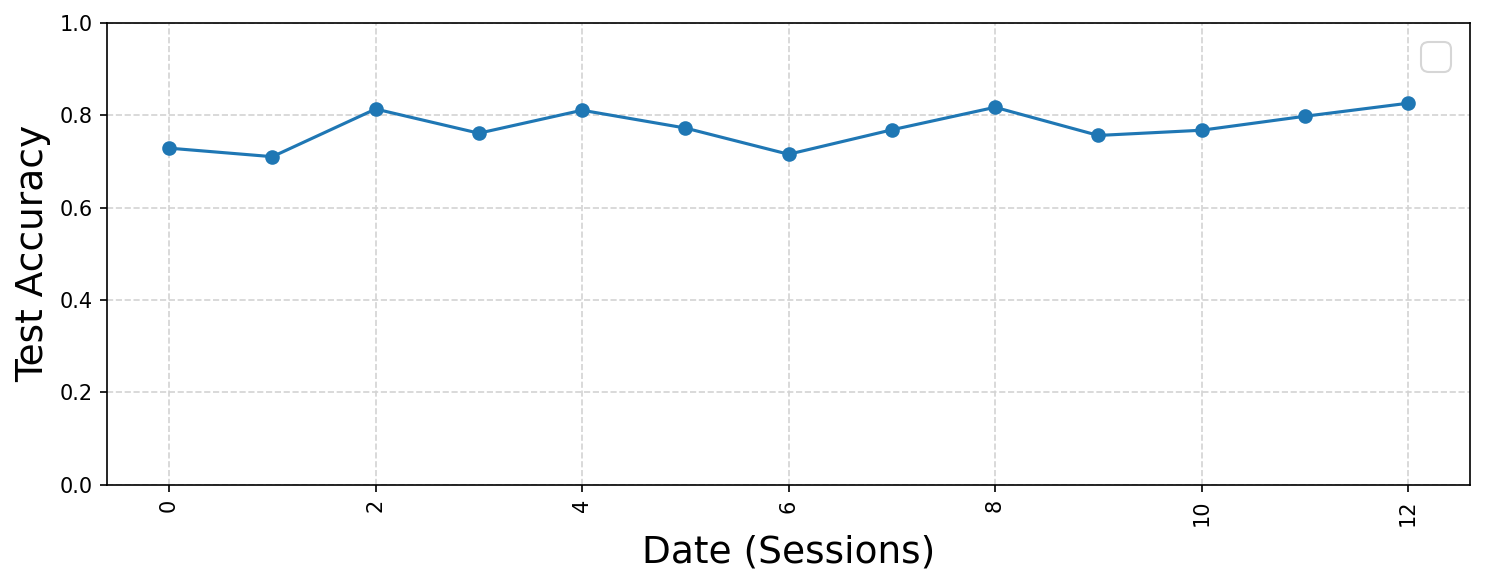

In [9]:
plt.figure(figsize=(10, 4), dpi=150)
plt.plot(Proto_Fixed_Acc, marker='o')

plt.ylim([0, 1])
#plt.ylim([0.6, 1])
plt.xlabel('Date (Sessions)', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=18)
plt.xticks(rotation=90, fontsize=10)
plt.legend(fontsize=18, ncol=4)
plt.grid(True, linestyle='--', color='lightgrey')
plt.tight_layout()
plt.show()